In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json

from ml_utils import *

In [3]:
torch.backends.cudnn.benchmark=True

In [4]:
PATH = Path('data/pascal/2007')
IMGS = 'VOCdevkit/VOC2007/JPEGImages'

## Single anchor box per cell

In [5]:
f_model=resnet34
sz=224
bs=64

In [6]:
aug_tfms = [RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ObjectDetectionData.from_csv(PATH, IMGS, PATH/'classes_and_bbs.csv', tfms=tfms, val_ratio=0.2)

In [7]:
get_color = Int2Color(12)

In [8]:
x,y=to_np(next(iter(md.val_dl)))
x=md.val_ds.ds.denorm(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


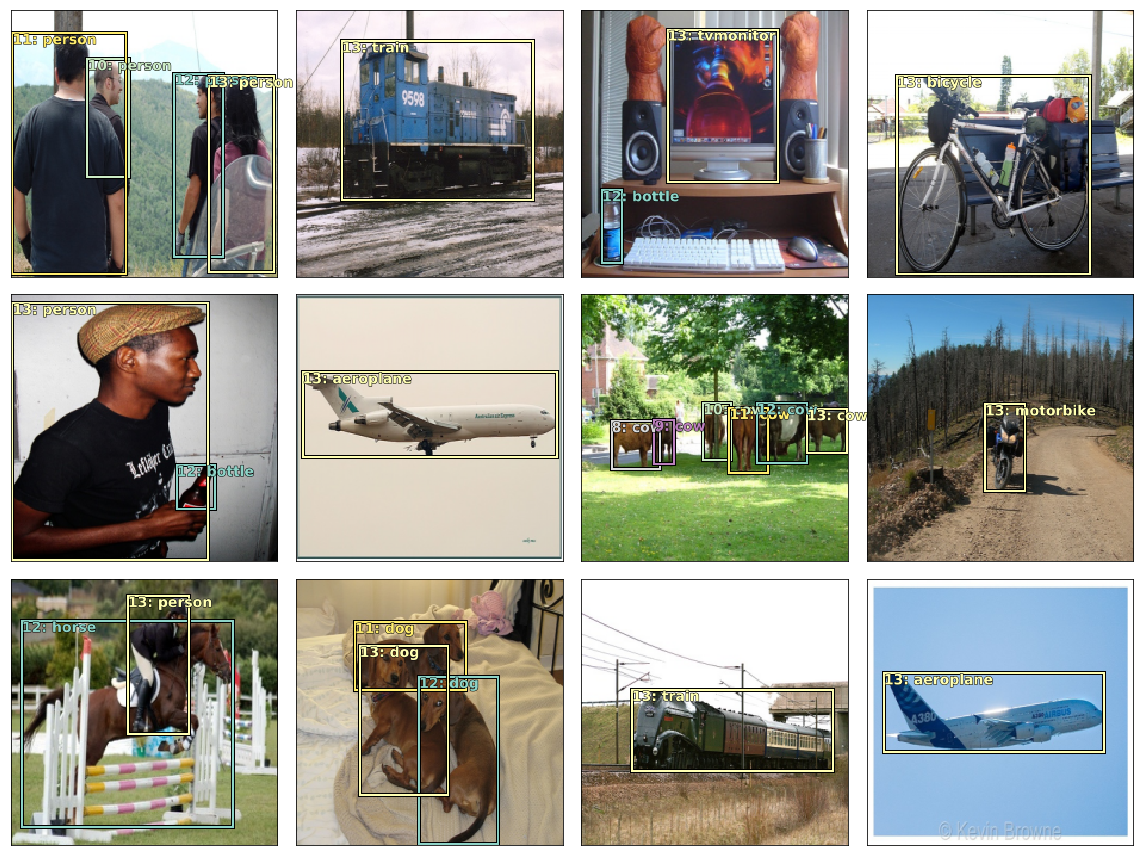

In [9]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
picked_ids = set()
for i,ax in enumerate(axes.flat):
    ri = np.random.randint(bs)
    while ri in picked_ids: ri = np.random.randint(bs)
    picked_ids.add(ri)
    show_ground_truth(ax, x[ri], y[1][ri], y[0][ri], md.classes)
plt.tight_layout()

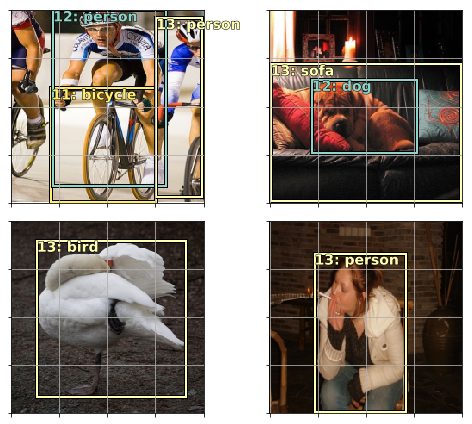

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[1][i], y[0][i], md.classes, show_grid=True)
plt.tight_layout()

####  Building the model

In [144]:
anc_grid_size = 2 # num of rows / columns
k = 1 # num of anchor boxes per grid cell

anc_offset = 1/(anc_grid_size * 2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid_size), anc_grid_size)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid_size), anc_grid_size)

anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid_size,1/anc_grid_size] for i in range(anc_grid_size*anc_grid_size)])

# The below line will make the anc_sizes have the necessary shape for this to work with k > 1, but it
# doesn't make sense from the perspective of the cost function - we need the boxes to be of varying size.
# anc_sizes = np.repeat(anc_sizes, k, 0)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

In [145]:
anchors

Variable containing:
 0.2500  0.2500  0.5000  0.5000
 0.2500  0.7500  0.5000  0.5000
 0.7500  0.2500  0.5000  0.5000
 0.7500  0.7500  0.5000  0.5000
[torch.cuda.FloatTensor of size 4x4 (GPU 0)]

In [146]:
# With just one anchor box per grid cell we could let this be a Python float, but we will
# want various shapes and sizes down the road when k > 1.
grid_sizes = V(np.array([1/anc_grid_size]), requires_grad=False).unsqueeze(1)
grid_sizes

Variable containing:
 0.5000
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

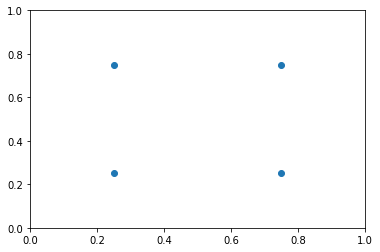

In [147]:
plt.scatter(anc_x, anc_y)
plt.xlim(0, 1)
plt.ylim(0, 1);

In [149]:
def ctrhw2corners(ctr, hw):
    '''
    Args:
        ctr: y, x coordinates of centers given as an (n, 2) tensor
        hw: h, w of each box
        
    Returns:
        Top left bottom right coordinates of a box in fastai format.
    '''
    return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [150]:
anchors

Variable containing:
 0.2500  0.2500  0.5000  0.5000
 0.2500  0.7500  0.5000  0.5000
 0.7500  0.2500  0.5000  0.5000
 0.7500  0.7500  0.5000  0.5000
[torch.cuda.FloatTensor of size 4x4 (GPU 0)]

In [151]:
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_cnr

Variable containing:
 0.0000  0.0000  0.5000  0.5000
 0.0000  0.5000  0.5000  1.0000
 0.5000  0.0000  1.0000  0.5000
 0.5000  0.5000  1.0000  1.0000
[torch.cuda.FloatTensor of size 4x4 (GPU 0)]

In [127]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))

In [128]:
def flatten_conv(x,k):
    bs,nf,gy,gx = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

In [129]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(md.classes)+1)*k, 3, padding=1) # (20+1)x4x4 with k == 1
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1) #  4x4x4 with k == 1, those will be predicted offsets
        # to centers and widths and heights of the anchor boxes
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [130]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1) # 7x7
        self.sconv1 = StdConv(256,256)

        self.sconv1 = StdConv(256,256) # 4x4
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x)
        return self.out(x)

In [131]:
def ssd_loss(pred,targ):
    lcs,lls = 0.,0.
    for b_c,b_bb,clas,bbox in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas)
        lls += loc_loss
        lcs += clas_loss
    return lls+lcs

In [132]:
def intersect(box_a, box_b):
    """ Intersection of every box_a with every box_b
    With 2 target bounding boxes,
    
    shapes (example):
        box_a: (2, 4)
        box_b: (16, 4)
        box_a[:, None, 2:]: (2, 1, 2)
        box_b[None, :, 2:]: (1, 16, 2)
        
        box_a[:, None, :2]: (2, 1, 2)
        box_b[None, :, :2]: (1, 16, 2)
        
        max_xy: (2, 16, 2)
        min_xy: (2, 16, 2)
        
        inter: (2, 16, 2)
        inter[:, :, 0] * inter[:, :, 1]: (2, 16)
        
    legend:
        max_xy: the lower right hand corner of the resultant intersection
        min_xy: the upper left hand corner
        
        inter[:, :, 0]: intersection heigth
        inter[:, :, 1]: intersection width
        
    """
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): 
    """ Area of boxes
    
    shapes:
        b: (n, 4)
        
    result shape: (n,)
    """
    return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    """ Calculate the IOU (intersection over union) for two sets of boxes
    
    shapes (example):
        box_a: (3, 4)
        box_b: (16, 4)
        
        inter: (3, 16)
        box_sz(box_a): (3,)
        box_sz(box_b): (16,)
        sum after unsqueezing: (3, 16)
        
        inter / union: (3, 16)
    
    """
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [133]:
def map_to_ground_truth(overlaps):
    """
    Arguments:
        overlaps: a (gt, anchor_count) array with jaccard score between each pair
    
    With 2 target bounding boxes and a 4x4 grid
    
    shapes (example):
        overlaps: (2, 16)
        prior_overlap: (2,)
        prior_idxs: (2,)
        
        gt_overlap: (16,)
        gt_idx: (16,)
        
    legend:
        overlaps: overlap between all gts (target bounding boxes) and anchors
        
        prior_overlap: gt overlap with anchor boxes    
        gt_overlap: anchor boxes overlap with gt
        gt_idx: idx of gt (bounding box) that overlaps most with the anchor box
        
    returns:
        An area of max overlap with any gt for each anchor box and the idx of the gt
        of maximium overlap.

    """
    prior_overlap, prior_idx = overlaps.max(1)
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i # this seems arbitrary - if there is an object with a 
        # smaller area in an anchor, and one with bigger, but for the smaller its the only anchor box it
        # appears in, we want to predict the smaller one - sounds like a tough thing to ask our NN for,
        # at the same time seems like this is the only way to attemtp to predict for every gt (assuming there
        # exist enough anchor boxes)
    return gt_overlap,gt_idx

In [134]:
def ssd_1_loss(b_c,b_bb,bbox,clas):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors) # these are predicted bounding boxes (anchors modified by offsets)
    overlaps = jaccard(bbox.data, anchor_cnr.data) # overlaps shape: (len(bbox), 16) for k = 1 and anc_grid = 4,
    gt_overlap,gt_idx = map_to_ground_truth(overlaps)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4 # we consider as positive examples such anchor boxes that are either the ones that our gt
    # overlaps most with - regardless of the area of overlap, or ones where the overlap of gt and an anchor box is < 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(md.classes) # this is a neat trick - we don't want to
    # predict the bg class, but we need to somehow mark empty gt boxes
    #
    # Problem is class 0 already means something so that will not work. We could set
    # the gt to None but that might mean we would need to do something tricky at some point
    #
    # To simplify the matters, we set the gt to class len(classes) + 1 to indicate background. This works nicely
    # with one hot encoding that we do later on and allows us to very efficiently (in terms of lines of code and clarity)
    # chop off this information for cost calculation.
    #
    # Objects that overlap most with a single anchor box and where the less overlapping object does not overlap with
    # another anchor > 0.4 will be disregarded (easy to fix via greater number of anchor boxes)
    gt_bbox = bbox[gt_idx] # grabbing the gt bbox that overlaps with an anchor box the most
        # its okay if len(gt_idx) > len(bbox) as long as all gt_idx < len(bbox) - 1
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean() # only the activations for anchor boxes with obj count!
    clas_loss = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

In [135]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:, :-1].contiguous())
        x = pred[:, :-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(20)

In [136]:
def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

In [137]:
def get_y(bbox,clas):
    """Get only nonzero target bounding boxes and classes"""
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

In [138]:
custom_head = SSD_Head(k, -3.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=custom_head)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
k

1

In [139]:
learn.crit = ssd_loss

In [140]:
lr = 3e-3
lrs = np.array([lr/100,lr/10,lr])

In [143]:
learn.fit(lr, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      38.541368  32.044751 



[array([32.04475])]

In [118]:
%debug

> <ipython-input-101-2ef420b69b8a>(3)actn_to_bb()
      1 def actn_to_bb(actn, anchors):
      2     actn_bbs = torch.tanh(actn)
----> 3     actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
      4     actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
      5     return hw2corners(actn_centers, actn_hw)

ipdb> grid_sizes
0.5
ipdb> actn_bbs.shape
torch.Size([16, 4])
ipdb> anorhs.shape
*** NameError: name 'anorhs' is not defined
ipdb> anchors.shape
torch.Size([4, 4])
ipdb> exit


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      109.391423 34691.744641



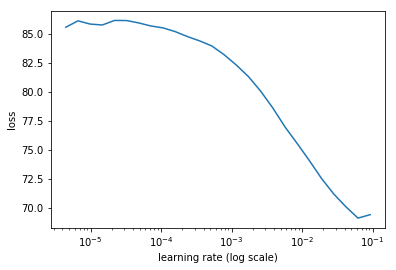

In [114]:
learn.lr_find(lrs/1000,1.)
learn.sched.plot(1)

In [52]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      42.719117  32.906019 
    1      33.607128  28.362409                           
    2      29.485265  27.377349                           
    3      26.603607  26.148101                           
    4      24.430272  25.874025                           



[array([25.87403])]

In [56]:
learn.freeze_to(-2)

In [91]:
for l in learn.model:
    print(type(l).__name__, l.trainable)

Conv2d False
BatchNorm2d False
ReLU False
MaxPool2d False
Sequential False
Sequential False
Sequential True
Sequential True
SSD_Head True


In [92]:
learn.fit(lrs, 1, cycle_len=3, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      27.506117  31.301079 
    1      25.499472  27.919765                           
    2      22.752238  24.960926                           



[array([24.96093])]

In [93]:
# learn.save('single_anchor')

In [222]:
learn.load('single_anchor')

### Visualizing results

In [154]:
x,y = next(iter(md.val_dl))

In [91]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.4, show_grid=False):
    bb = [bb_fastai_to_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_im(im, ax=ax, show_grid=show_grid)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(md.classes) else md.classes[int(c)])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

In [193]:
def show_torch_ground_truth(im, bbs, clas=None, ax=None, **kwargs):
    im, bbs = to_np(im), to_np(bbs)
    if clas is not None: clas = to_np(clas)
    if ax is None: ax = plt.subplots(figsize=(7,7))[1]
    show_ground_truth(ax, md.trn_ds.denorm(im)[0], bbs, clas, **kwargs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


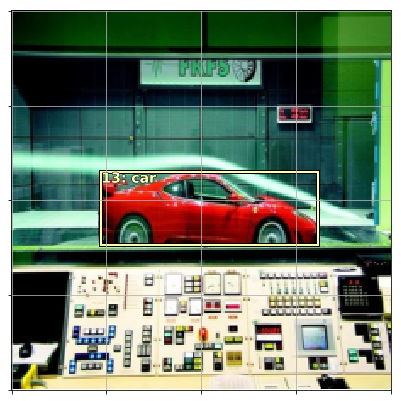

In [236]:
idx = 11
show_torch_ground_truth(x[idx], y[1][idx], y[0][idx], show_grid=True)

In [284]:
def show_torch_predictions(im, bbs, clas=None, ax=None, show_bg=True, **kwargs):
    im, bbs = to_np(im), to_np(actn_to_bb(b_bb[idx], anchors) * sz)
    if clas is not None: clas = to_np(b_c[idx].max(1)[1])
    if ax is None: ax = plt.subplots(figsize=(7,7))[1]
    if not show_bg:
        non_bg_idx = clas != 20
        bbs, clas = bbs[non_bg_idx], clas[non_bg_idx]
    show_ground_truth(ax, md.trn_ds.denorm(im)[0], bbs, clas, **kwargs)

In [238]:
b_c, b_bb = learn.model(V(x))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


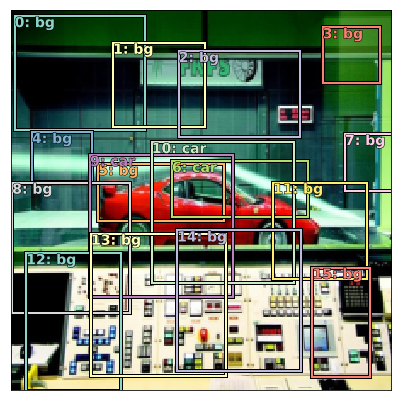

In [287]:
show_torch_predictions(x[idx], b_bb[idx], b_c[idx])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


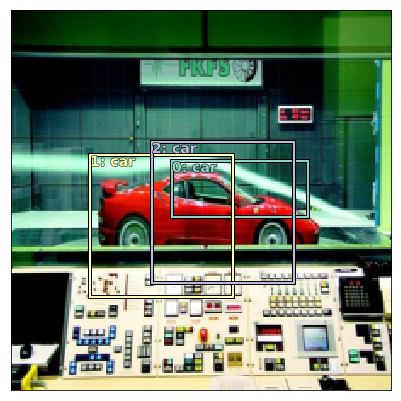

In [286]:
show_torch_predictions(x[idx], b_bb[idx], b_c[idx], show_bg=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


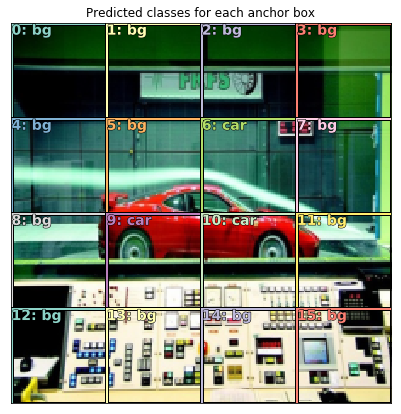

In [243]:
fig, ax = plt.subplots(figsize=(7, 7))
show_ground_truth(ax, md.trn_ds.denorm(x)[idx], to_np(anchor_cnr * sz), to_np(b_c[idx].max(1)[1]))
plt.title('Predicted classes for each anchor box');